In [54]:
####### Python packages ########
####### Please uncomment the followings to install the packages which, required to run this code 
# !pip install statsmodels==0.12.1  ##(dependencies for statsmodels are; 
#                                   ## python >=3.6, Numpy >=1.15, SciPy >=1.2, Pandas >=0.23, Patsy >=0.5.1)
# !pip install pandas
# !pip install plotly
# !pip install networkx
# !pip install numpy
# !pip install seaborn
# !pip install scipy


In [55]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import seaborn as sns
import decimal
import glob
import plotly 
import plotly.plotly as py
from collections import OrderedDict
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

###### Initialization

In [56]:
relationshipTypes=['creationTocreation', 'creationTocontribution', 'creationTosharing', 
                   'contributionTocreation', 'contributionTocontribution', 'contributionTosharing', 
                   'sharingTocreation', 'sharingTocontribution', 'sharingTosharing']
platforms = ["GitHub","Twitter"]
communities = ["Crypto","CVE"]

In [57]:
def indegZeroUsers(G):
    '''
    Select users with indegree zero
    
    '''
    indegrees=list(G.in_degree(G.nodes()))
    indegree_zero_users = [indegree[0] for indegree in indegrees if indegree[1] == 0 ]
    print (f'number of indeg zero users {len(indegree_zero_users)}')
    return indegree_zero_users

In [58]:
def influenceCascadeExtraction(root_list,G):
    '''
    Extracting influence cascades rooted from a given root users list.
    
    '''   

    influence_df = pd.DataFrame()
    root_child_df = pd.DataFrame()

    for root in root_list: 

        data=[] # a list contains the influence vectors of users in each levels of hierarchy 
        Queue=[] # a list wich store nodes tempararily 
        hopdists={} # distance from root to nodes. key: node, value: distance from root

        Queue.insert(0,root)    
        hopdists[root] = 0

        while len(Queue) > 0:
            currentNode = Queue.pop()
            hopdist = hopdists[currentNode]
            outEdges = G.out_edges(currentNode,True)
            for edge in outEdges:
                influenceVector= [edge[2]['creationTocreation'], edge[2]['creationTocontribution'], 
                                  edge[2]['creationTosharing'],edge[2]['contributionTocreation'],
                                  edge[2]['contributionTocontribution'],edge[2]['contributionTosharing'],
                                  edge[2]['sharingTocreation'],edge[2]['sharingTocontribution'],
                                  edge[2]['sharingTosharing']]
                child = edge[1]
                if not child in hopdists.keys(): # check whether the node is already counted
                    if len(data) < (hopdist+1):  
                        data.append([])          # create sublists in data list for each hop
                    # store influence vectors of nodes in their corresponding sublist in data list
                    data[hopdist].append(influenceVector) 
                    # add the child node to Queue to consider it as a parent node in the next rounds
                    Queue.insert(0,child)                 
                    hopdists[child] = hopdist + 1   
        
        ##### Characterization of influence vector components #####
        levelInfluenceValues=[zip(*hop) for hop in data]    
        for i in range(len(levelInfluenceValues)):
            # total influence by activity type at each level of the cascade 
            levelInfluenceValues[i] = [sum(j) for j in levelInfluenceValues[i]]  
        
        levels = list(range(1, len(levelInfluenceValues)+1))
        levelInfluenceValues = np.array(levelInfluenceValues).T # total linfluence values at each level by activity type
        
        for idx, l in enumerate(levelInfluenceValues):
            m = np.sum(l)
            levelInfluenceValues[idx] = np.array(l) / m  # normalized total influence at each level by activity type   

        this_root_influence_by_levels = {}
        for idx, relation in enumerate(relationshipTypes):
            this_root_influence_by_levels[relation]=levelInfluenceValues[idx]
        this_root_influence_by_levels = pd.DataFrame(this_root_influence_by_levels)
    
        this_root_influence_by_levels["level"]=levels 
        this_root_influence_by_levels["root"]=root
        influence_df = influence_df.append(this_root_influence_by_levels,ignore_index=True)  
        
        ##### node-level data extraction of cascades for statistical analysis #######
        cascade_node_data = {'node':list(dict(hopdists).keys()), 'node_level':list(dict(hopdists).values())}
        root_child_by_levels = pd.DataFrame(cascade_node_data)
        root_child_by_levels["root"] = root
        root_child_df = root_child_df.append(root_child_by_levels,ignore_index = True) 

    print('influenceCascades_df')
    print (influence_df.head())
    return influence_df, root_child_df

In [59]:
def generateScaleFreeNetworks(n):
    '''
    Generate scale-free networks with n number of nodes
    '''
    G_scaleFree = nx.scale_free_graph(n, seed=30)# scale free graph with default probabilities (alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, create_using=None,)

    np.random.seed(0)
    def setDecimals(x):
        decimal.getcontext().prec = 10  # 10 decimal points enough
        return decimal.Decimal(0) + decimal.Decimal(x)
    # this should include both boundaries as float gets close enough to 1 to make decimal round

    edges = list(set(G_scaleFree.edges()))
    scalefree_network = pd.DataFrame(edges, columns = ["userID1","userID0" ], dtype= str)
    scalefree_network = scalefree_network[scalefree_network["userID0"]!= scalefree_network["userID1"]]
    for action in relationshipTypes:
        scalefree_network[action] = np.random.uniform(0,1, scalefree_network.shape[0])
        scalefree_network[action] = scalefree_network[action].apply(lambda x: setDecimals(x)).astype(float) 
    scalefree_inflnetwork = scalefree_network[scalefree_network.iloc[:,2:].sum(axis=1) > 0]
    return scalefree_inflnetwork

In [60]:
def CreateDataFrames():
    '''
    Create relevent data frames
    Returns;
    1)empirical_inflcascades_df, 2)empirical_rootchild_df,
    3)scalefree_inflcascades_df, 4)scalefree_rootchild_df
    '''

    empirical_inflcascades_df = pd.DataFrame()
    empirical_rootchild_df = pd.DataFrame()
    empirical_inflnetworks_nodecount = OrderedDict()
    scalefree_inflcascades_df = pd.DataFrame()
    scalefree_rootchild_df = pd.DataFrame()

    for platform in platforms:
        for community in communities:
            platform_community = str(platform)+"_"+str(community)
            inflnetwork_gt=pd.read_csv("input_data/"+platform_community+"_Influence_Network_df.csv")
            print (platform_community)
            G=nx.from_pandas_edgelist(inflnetwork_gt,'userID0','userID1',inflnetwork_gt.columns.tolist()[2:],
                                       create_using=nx.DiGraph())
            empirical_inflnetworks_nodecount[platform_community] = G.number_of_nodes()
            indeg_zero_users = indegZeroUsers(G) # finding in-degree zero nodes (source nodes) in the influence network
            inflcascades_df, root_child_df = influenceCascadeExtraction(indeg_zero_users,G) # extracting influence cascades of source nodes
    
            #### storing influence cascades dfs and root_child dfs for statistical analysis 
            inflcascades_df["platform"] = platform
            inflcascades_df["community"] = community
            empirical_inflcascades_df = empirical_inflcascades_df.append(inflcascades_df)
            root_child_df["platform"] = platform
            root_child_df["community"] = community
            root_child_df["platform_community"] = platform_community
            empirical_rootchild_df = empirical_rootchild_df.append(root_child_df)

            #### comparison with scale-free networks ######
            print ("SF_"+platform_community)
            scalefree_inflnetwork = generateScaleFreeNetworks(G.number_of_nodes()) #generating scale-free networks with equal number of nodes in empirical network
            G_SF = nx.from_pandas_edgelist(scalefree_inflnetwork,'userID0','userID1',scalefree_inflnetwork.columns.tolist()[2:],
                                       create_using=nx.DiGraph())
            indeg_zero_users_SF = indegZeroUsers(G_SF) # finding in-degree zero nodes (source nodes) in the influence network
            inflcascades_df_SF, root_child_df_SF = influenceCascadeExtraction(indeg_zero_users_SF,G_SF) # extracting influence cascades of source nodes

            #### Storing influence cascades dfs of scale-free networks for statistical analysis
            inflcascades_df_SF["platform"] = platform
            inflcascades_df_SF["community"] = community
            scalefree_inflcascades_df = scalefree_inflcascades_df.append(inflcascades_df_SF)
            root_child_df_SF["platform"] = platform
            root_child_df_SF["community"] = community
            root_child_df_SF["platform_community"] = "SF_"+ str(platform_community)
            scalefree_rootchild_df = scalefree_rootchild_df.append(root_child_df_SF)
            #### Return
    return empirical_inflcascades_df,empirical_rootchild_df,scalefree_inflcascades_df,scalefree_rootchild_df 

###### Analysis

In [61]:
def InfluenceDistribution(empirical_inflcascades_df,scalefree_inflcascades_df):
    '''
    Analysis of the residuals differences between the median normalized total influence values extracted 
    from influence cascades and those from influence cascades generated by the corresponding null model
    '''
    empirical_inflcascades_medians = empirical_inflcascades_df.groupby(by=["platform","community","level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
    scalefree_inflcascades_meidans = scalefree_inflcascades_df.groupby(by=["platform","community","level"]).median().fillna(0).reset_index()
    residual_df = empirical_inflcascades_medians.set_index(["platform","community","level"]).subtract(scalefree_inflcascades_meidans.set_index(["platform","community","level"]), fill_value=0).reset_index()
    residual_df["platform_community"]=residual_df["platform"]+"_"+residual_df["community"]
    supremum_level=min(list(residual_df.groupby(["platform_community"])["level"].max()))
    truncated_residual_df = residual_df[residual_df["level"]<=supremum_level]

    ###### Plotting residuals of median normalized total influence values #######
    print("Plotting residuals of median normalized total influence values")
    df=pd.melt(truncated_residual_df, id_vars=["level","platform_community"], value_vars=truncated_residual_df.columns[3:-1],
               var_name="inf_relationship", value_name="influence")
    df["inf_relationship"]=df["inf_relationship"].str.replace("creation","initiation") # replace the word "creation" by "initiation"
    with sns.plotting_context("paper",font_scale=1.9):
        f= sns.relplot(x="level", y="influence", col="inf_relationship", col_wrap=3, hue="platform_community", 
                       palette=["C0","C1","C2","k"], kind="line", linewidth=2, data=df, height=4.9, aspect=0.8)
        (f.map(plt.axhline, y=0, color=".7", dashes="", lw=2))

        f.set_xlabels("Level",fontsize= 20)
        f.set_ylabels("Influence",fontsize= 20)
        f.set_titles("{col_name}",fontsize=18)
        f.fig.subplots_adjust(wspace=0.2)
        leg = f._legend
        leg.texts[0].set_text("")
        f.set(xticks=df.level[0::1])    
    plt.show()


    ##### Spearman's correlation test between platforms and community by influence relationships
    #####(only first four levels are considered)
    def corrByRelationship(df1,df2):
        corr_coef_by_relationship = {}
        corr_p_by_relationship = {}
        for relation in relationshipTypes:
            corr_coef_by_relationship[relation]=scipy.stats.spearmanr(np.array(df1[relation]), np.array(df2[relation]))[0]
            corr_p_by_relationship[relation]=scipy.stats.spearmanr(np.array(df1[relation]), np.array(df2[relation]))[1]
        return corr_coef_by_relationship,corr_p_by_relationship


    spearmann_df = pd.DataFrame(columns=["inf_relationship"])
    spearmann_df["inf_relationship"]=relationshipTypes
    pd.set_option("display.precision",8)
    for platform in ["GitHub","Twitter"]:
        df1 = truncated_residual_df[truncated_residual_df["platform_community"]==platform+"_Crypto"]
        df2 = truncated_residual_df[truncated_residual_df["platform_community"]==platform+"_CVE"]
        coeff,pvalue = corrByRelationship(df1,df2)
        spearmann_df[platform+"_Crypto/"+platform+"_CVE_coef"]=spearmann_df["inf_relationship"].map(coeff)
        spearmann_df[platform+"_Crypto/"+platform+"_CVE_p"]=spearmann_df["inf_relationship"].map(pvalue)
    for community in ["Crypto","CVE"]:
        df1 = truncated_residual_df[truncated_residual_df["platform_community"]=="GitHub_"+community]
        df2 = truncated_residual_df[truncated_residual_df["platform_community"]=="Twitter_"+community]
        coeff,pvalue = corrByRelationship(df1,df2)
        spearmann_df["GitHub_"+community+"/Twitter_"+community+"_coef"]=spearmann_df["inf_relationship"].map(coeff)
        spearmann_df["GitHub_"+community+"/Twitter_"+community+"_p"]=spearmann_df["inf_relationship"].map(pvalue)
    spearmann_df=spearmann_df.fillna(0)
    spearmann_df["inf_relationship"]=spearmann_df["inf_relationship"].str.replace("creation","initiation") # replace the word "creation" by "initiation"
    spearmann_df.to_csv("spearmannStats.csv") 
    print("Spearmann's Correlation Test")
    print(spearmann_df)


    ##### Scatter plots of Median normalized total influence values across platforms and comminities by 
    #####influence relationships
    print("Plotting Meadian Normalized Total Influence Values Across Platforms and Communitites")
    for platform in ["GitHub","Twitter"]:
        df3= truncated_residual_df[truncated_residual_df["platform"]==platform].drop(columns="platform")
        df3=pd.melt(df3, id_vars=["level","community"], 
                value_vars=truncated_residual_df.columns[3:-1],var_name="inf_relationship", value_name="influence")
        df3 = pd.pivot_table(df3,values="influence", index=["level","inf_relationship"],columns="community").reset_index()
        df3["inf_relationship"]=df3["inf_relationship"].str.replace("creation","initiation")
        g = sns.FacetGrid(df3, col="inf_relationship",col_wrap=3)
        g = (g.map(plt.scatter, "CVE", "Crypto").set_titles("{col_name}"))
        print(platform)
        plt.show()    
    for community in ["Crypto", "CVE"]:
        df4= truncated_residual_df[truncated_residual_df["community"]==community].drop(columns="community")
        df4=pd.melt(df4, id_vars=["level","platform"], 
                value_vars=truncated_residual_df.columns[3:-1],var_name="inf_relationship", value_name="influence")
        df4 = pd.pivot_table(df4,values="influence", index=["level","inf_relationship"],columns="platform").reset_index()
        df4["inf_relationship"]=df4["inf_relationship"].str.replace("creation","initiation") 
        g = sns.FacetGrid(df4, col="inf_relationship",col_wrap=3)
        g = (g.map(plt.scatter, "GitHub", "Twitter").set_titles("{col_name}"))
        print(community)
        plt.show()

In [62]:
def UserDistributions(empirical_rootchild_df,scalefree_rootchild_df):
    '''
    Analysis of user distributions 
    '''
    rootchild_data = pd.concat([empirical_rootchild_df,scalefree_rootchild_df], axis=0)
    user_count_at_levels = rootchild_data.groupby(["platform","community","platform_community","root","node_level"]).size().reset_index().rename(columns={0:"num_nodes"})
    avg_user_count_at_levels = user_count_at_levels.groupby(["platform","community","platform_community","node_level"]).mean().reset_index()
    avg_user_count_at_levels["network"] = avg_user_count_at_levels["platform_community"].apply(lambda x: "Scale-free" if "SF" in x else "Empirical") 
    avg_user_count_at_levels["diff"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].diff(periods=1)
    avg_user_count_at_levels["cumulative_sum_of_users"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].apply(lambda x: x.cumsum())
    avg_user_count_at_levels["norm_num_nodes"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].apply(lambda x : x/x.max())
    avg_user_count_at_levels["norm_cumulative_sum_of_users"] =avg_user_count_at_levels.groupby("platform_community")["cumulative_sum_of_users"].apply(lambda x: x/x.max())
    avg_user_count_at_levels["norm_diff"] = avg_user_count_at_levels.groupby("platform_community")["diff"].apply(lambda x : x/abs(x).max())
    
    #### Mean number of users per cascade level by platform and community
    with sns.plotting_context("paper",font_scale=2):
        print("Plotting Mean number of users per cascade level by platform and community")
        h1 = sns.catplot(x="node_level", y="norm_num_nodes", row="platform",col="community",hue="network",palette=["C0","C1"],kind="bar",
                    data=avg_user_count_at_levels)
        h1.set_xlabels("Level",fontsize= 20)
        h1.set_ylabels("Total Number of Users",fontsize= 20)
        h1.set_titles('{row_name}' ' | ' '{col_name}',fontsize=20)
        h1.fig.subplots_adjust(wspace=0.1)
        h1._legend.set_title("")
    plt.show()    
      
    #### Cumulative mean number of users per cascade level by platform and community
    print("Plotting cumulative mean number of users per cascade level by platform and community")
    with plt.rc_context(dict(sns.axes_style("whitegrid",{'grid.linestyle': '--'}),
                             **sns.plotting_context("paper", font_scale=2))):
        h2=sns.relplot(x="node_level", y="norm_cumulative_sum_of_users", row="platform",col="community",hue="network",palette=["C0","C1"],
                       kind="line", data=avg_user_count_at_levels, linewidth=3)    
        h2.set_xlabels("Level",fontsize= 20)
        h2.set_ylabels("Cumulative Sum of Users",fontsize= 20)
        h2.set_titles('{row_name}' ' | ' '{col_name}',fontsize=20)
        h2.fig.subplots_adjust(wspace=0.1)
        h2._legend.texts[0].set_text("")
    plt.show()
    
    ####################### JS-divergence tests ########################################
    #### JS-divergence of mean number of nodes distribution between each empirical network
    print("JS-divergence test of mean number of nodes distribution between each empirical network")
    from scipy.spatial import distance
    jstest_df=avg_user_count_at_levels[avg_user_count_at_levels["network"]=="Empirical"]
    dist={}
    for x in list(jstest_df["platform_community"].unique()):
        for y in list(jstest_df["platform_community"].unique()):        
            df1= jstest_df[jstest_df["platform_community"]==x]
            df2= jstest_df[jstest_df["platform_community"]==y]
            m = min(df1["node_level"].max(),df2["node_level"].max())       
            df1= df1[df1["node_level"]<=m]
            df2= df2[df2["node_level"]<=m]
            dist[x,y]=distance.jensenshannon(np.array(df1["norm_num_nodes"]), np.array(df2["norm_num_nodes"]))

    df = {}
    df["platform_community_comb"]=list(dist.keys())
    df["distance"]=list(dist.values())

    df1 = pd.DataFrame(df)
    df1.drop_duplicates()
    print(df1.sort_values(by=['distance']))
    df1.sort_values(by=['distance']).to_csv("JSTestMeanUserDist.csv")
    
    #### JS-divergence of cumulative user distributions between each network
    print("JS-divergence test of cumulative user distributions between each network")
    from scipy.spatial import distance
    dist={}
    for x in list(avg_user_count_at_levels["platform_community"].unique()):
        for y in list(avg_user_count_at_levels["platform_community"].unique()):        
            df1= avg_user_count_at_levels[avg_user_count_at_levels["platform_community"]==x]
            df2= avg_user_count_at_levels[avg_user_count_at_levels["platform_community"]==y]
            m = min(df1["node_level"].max(),df2["node_level"].max())       
            df1= df1[df1["node_level"]<=m]
            df2= df2[df2["node_level"]<=m]
            dist[x,y]=distance.jensenshannon(np.array(df1["norm_cumulative_sum_of_users"]), np.array(df2["norm_cumulative_sum_of_users"]))

    df = {}
    df["platform_community_comb"]=list(dist.keys())
    df["distance"]=list(dist.values())

    df1 = pd.DataFrame(df)
    df1.drop_duplicates()
    df1.sort_values(by=['distance'])
    df1.to_csv("JSTestCumulativeUserDist.csv")
    print(df1)

In [63]:
def Anova(empirical_inflcascades_df,scalefree_inflcascades_df):
    '''
    Three-way ANOVA: 
    '''
    scalefree_inflcascades_medians = (scalefree_inflcascades_df.groupby(by=["platform","community","level"])
                                      .median().fillna(0).reset_index())
    
    res_df = pd.DataFrame()
    for platform in ["GitHub","Twitter"]:
        for community in ["Crypto","CVE"]:
            df_SF = scalefree_inflcascades_medians[(scalefree_inflcascades_medians["platform"]==platform) & 
                                                   (scalefree_inflcascades_medians["community"]==community)]
            df_gt = empirical_inflcascades_df[(empirical_inflcascades_df["platform"]==platform) & 
                                              (empirical_inflcascades_df["community"]==community)]
            root_users=set(df_gt.root.unique())
            random.seed(0)
            random_root_users_sample = random.sample(root_users,k=40)
            for user in random_root_users_sample:
                user_df_gt = df_gt[df_gt["root"] == user]
                user_df_gt = user_df_gt.drop(columns="root")
                temp_residual_df = (user_df_gt.set_index(["platform","community","level"])
                .subtract(df_SF.set_index(["platform","community","level"]), fill_value=0).reset_index())
                res_df = res_df.append(temp_residual_df)
    res_df = res_df[res_df["level"]<=4]
    res_df["platform_community"] = res_df["platform"]+"_"+res_df["community"]
    anova_data=pd.melt(res_df, id_vars=["level","platform_community"], value_vars=relationshipTypes, var_name="inf_relationship", value_name="influence")

    ###### Normality check for each combination of groups of the platform_community, influence relationship and level ######
    threewayAnovaNormality=(anova_data.groupby(["platform_community","inf_relationship","level"])
             .apply(lambda x: pd.Series(scipy.stats.shapiro(x), index=['stats','P']))
             .reset_index())
    threewayAnovaNormality["H_0"] = threewayAnovaNormality["P"].apply(lambda x: "rejected" if x<0.05 else "not rejected")
    print("Three-way ANOVA Normality test", threewayAnovaNormality,sep='\n')
    print(f'{threewayAnovaNormality.groupby(["H_0"])["P"].count()}')
    threewayAnovaNormality = threewayAnovaNormality.rename(columns={"platform_community":"platformCommunity","inf_relationship":"infRelationship","H_0":"Null"})
    threewayAnovaNormality["platformCommunity"]=threewayAnovaNormality["platformCommunity"].str.replace("_","-")
    threewayAnovaNormality["stats"] = threewayAnovaNormality["stats"].map("{:.2f}".format)
    threewayAnovaNormality["P"] = threewayAnovaNormality["P"].map("{:.2E}".format)
    threewayAnovaNormality.to_csv("threewayANOVANormalityStats.csv",index=False)

    #### Normality check of residuals of the model####
    model = ols('influence~C(platform_community)+C(inf_relationship)+C(level)+C(platform_community):C(inf_relationship)+C(platform_community):C(level)+C(inf_relationship):C(level)+C(platform_community):C(inf_relationship):C(level)', data=anova_data).fit()
    print(f'Normality check of residuals of the three-way ANOVA model: {scipy.stats.shapiro(model.resid)}')
    fig = plt.figure(figsize= (10, 10))
    ax = fig.add_subplot(111)
    normality_plot, stat = scipy.stats.probplot(model.resid, plot= plt, rvalue= True)
    ax.set_title("Probability plot of model residual's", fontsize= 20)
    ax.set
    plt.show()

###### Plotting Influence Cascades

In [64]:
def CreateSankeyLinksAndNodes_dfs(flow_df):   
    '''
    Get links and nodes dataframes to create sankey plot using the median influence values of each influence type by level.
    Will return sankey_links_df and sankey_nodes_df.
    '''
    ############## link data to create sankey plot ###################
    sankey_links_df = flow_df.melt(id_vars=['level'])
    sankey_links_df['from_label'] = sankey_links_df.apply(lambda x: "C" if "contributionTo" in x.variable else ("S" if "sharingTo" in x.variable else "I"),axis=1)
    sankey_links_df['to_label'] = sankey_links_df.apply(lambda x: "C" if "Tocontribution" in x.variable else ("S" if "Tosharing" in x.variable else "I"),axis=1)
    sankey_links_df['from_id_temp'] = (sankey_links_df.level-1).astype(str) + sankey_links_df.from_label
    sankey_links_df['to_id_temp'] = sankey_links_df.level.astype(str) + sankey_links_df.to_label
   
    ###### Reassign from_id_temp and to_id_temp with integers. To create sankey plot, nodes ids should be integers######
    node_id=pd.DataFrame(columns=['node_id_temp'])
    node_id['node_id_temp']=sankey_links_df['from_id_temp'].append(sankey_links_df['to_id_temp']).reset_index(drop=True)
    node_id=node_id.drop_duplicates('node_id_temp',keep='first')
    node_id['node_id']=np.arange(len(node_id))
    
    sankey_links_df = pd.merge(sankey_links_df, node_id, how = 'left', left_on='from_id_temp', right_on='node_id_temp',sort = False ).drop(['node_id_temp', 'from_id_temp'], axis = 1).rename(columns = {'node_id': 'from_id'})   #reassign the temp_from_id 
    sankey_links_df = pd.merge(sankey_links_df, node_id, how = 'left', left_on='to_id_temp', right_on='node_id_temp',sort = False ).drop(['node_id_temp','to_id_temp'], axis = 1).rename(columns = {'node_id': 'to_id'}) #reassign the temp_to_id
    sankey_links_df['link_color'] = np.where((sankey_links_df.from_label == "C"), "rgb(144,237,244)", np.where((sankey_links_df.from_label == "I"),"rgb(247,203,81)", "rgb(225,174,242)"))
    # sankey_links_df.to_csv("output/sankey_links_df.csv")

    ################## node data to create sankey plot #################
    sankey_nodes_df=node_id.copy()
    sankey_nodes_df['node_label']=sankey_nodes_df['node_id_temp'].apply(lambda x: "C" if "C" in x else ("I" if "I" in x else ("S" if "S" in x else "Nan")))
    sankey_nodes_df['node_color'] = np.where((sankey_nodes_df.node_label == "C"),"rgb(60,222,234)",np.where((sankey_nodes_df.node_label == "I"),"rgb(232,176,25)", "rgb(213,128,242)"))
    sankey_nodes_df=sankey_nodes_df.drop(['node_id_temp'], axis=1)
    # sankey_nodes_df.to_csv("output/sankey_nodes_df.csv")

    return sankey_links_df,sankey_nodes_df

In [65]:
def plotSankey(sankey_links_df,sankey_nodes_df):
    '''
    plotting sankey graph
    '''
    
    #plotly.tools.set_credentials_file(username='username', api_key='api_key') 
    data = dict(
        type='sankey',
        arrangement = "freeform",
        opacity = 0.1,
        showlegend = True,
        textfont = dict (
            color = "black",
            size = 1, 
            family = "Droid Serif"      
        ),
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        node = dict(
          pad = 15,
          thickness = 30,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = sankey_nodes_df['node_label'].dropna(axis=0, how='any'),
          color = sankey_nodes_df['node_color'].dropna(axis=0, how='any')
        ),
        link = dict(
          source = sankey_links_df['from_id'],
          target = sankey_links_df['to_id'],
          value = sankey_links_df['value'],
          color = sankey_links_df['link_color'].dropna(axis=0, how='any')
      ))

    layout =  dict(
        autosize = False,
        height = 950,
        width = 1500,
        font = dict(
          size = 10
        )
    )

    fig = dict(data=[data], layout=layout)
    py.plot(fig)

In [71]:
def PlottingInfluenceCascades(empirical_rootchild_df,scalefree_rootchild_df):
    '''Plotting influence cascades (Sankey plots)'''
    for platform in platforms:
        for community in communities:
            ####Empirical influence cascades                        
            inflcascades_df = empirical_inflcascades_df[(empirical_inflcascades_df["platform"]==platform) & 
                                                        (empirical_inflcascades_df["community"]==community)]
            gt_infl_medians_by_level_and_type_df = inflcascades_df.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
            sankey_links_df,sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(gt_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization 
            plotSankey(sankey_links_df,sankey_nodes_df) # plotting influence cascades through Sankey diagram
            print("empirical", platform, community, "is plotted")
            ####Scale-free influence cascades            
            inflcascades_df_SF = scalefree_inflcascades_df[(scalefree_inflcascades_df["platform"]==platform) & 
                                                        (scalefree_inflcascades_df["community"]==community)]
            SF_infl_medians_by_level_and_type_df = inflcascades_df_SF.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
            SF_sankey_links_df,SF_sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(SF_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization
            plotSankey(SF_sankey_links_df,SF_sankey_nodes_df) # plotting influence cascades through Sankey diagram
            print("sacle-free", platform, community, "is plotted")

In [67]:
def GeneratingExampleScalefreeNetworks(): 
    ''' Generating example scale-free null models'''
    
    print("Generating example scale-free null models")
    #networksizes = [50,100,200,300,400,510,513,514,515,600,800,1000]
    networksizes = [50,510,1000]
    for n in networksizes:
        scalefree_inflnetwork = generateScaleFreeNetworks(n) #generating scale-free networks with equal number of nodes in empirical network
        G_SF = nx.from_pandas_edgelist(scalefree_inflnetwork,'userID0','userID1',scalefree_inflnetwork.columns.tolist()[2:],
                                   create_using=nx.DiGraph())
        indeg_zero_users_SF = indegZeroUsers(G_SF) # finding in-degree zero nodes (source nodes) in the influence network
        inflcascades_df_SF, root_child_df_SF = influenceCascadeExtraction(indeg_zero_users_SF,G_SF) # extracting influence cascades of source nodes
        SF_infl_medians_by_level_and_type_df = inflcascades_df_SF.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
        SF_sankey_links_df,SF_sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(SF_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization
        plotSankey(SF_sankey_links_df,SF_sankey_nodes_df)

###### Main entry point

In [74]:
def Main():
    ####Create Dataframes
    empirical_inflcascades_df,empirical_rootchild_df,scalefree_inflcascades_df,scalefree_rootchild_df=CreateDataFrames()
    print("Analysis started")
    UserDistributions(empirical_rootchild_df,scalefree_rootchild_df)
    InfluenceDistribution(empirical_inflcascades_df,scalefree_inflcascades_df)
    Anova(empirical_inflcascades_df,scalefree_inflcascades_df)
    print("Analysis completed.")
    print("Plotting influence cascades started")
    PlottingInfluenceCascades(empirical_rootchild_df,scalefree_rootchild_df)
    GeneratingExampleScalefreeNetworks()
    print("Influence_Cascade_Extraction_and_Visualization completed execution.")
    

GitHub_Crypto
number of indeg zero users 568


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0                 0.0                     0.0                NaN   
1                 1.0                     1.0                NaN   
2                 0.0                     0.0                NaN   
3                 0.0                     0.0                NaN   
4                 1.0                     1.0                NaN   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0              0.00000000                  0.02428225             0.00000000   
1              1.00000000                  0.94225329             0.90360900   
2              0.00000000                  0.03346446             0.09639100   
3              0.00000000                  0.02067387             0.00000000   
4              0.97082488                  0.87283779             0.69662999   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0                

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0                 NaN                     NaN                NaN   
1                 NaN                     NaN                NaN   
2                 NaN                     NaN                NaN   
3                 NaN                     NaN                NaN   
4                 NaN                     NaN                NaN   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                     NaN                  0.00536438                    0.0   
1                     NaN                  0.55744306                    1.0   
2                     NaN                  0.35771031                    0.0   
3                     NaN                  0.06233337                    0.0   
4                     NaN                  0.01714889                    0.0   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0                

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0           0.0000000              0.00000000         0.00000000   
1           1.0000000              0.98023903         0.99783728   
2           0.0000000              0.01976097         0.00216272   
3           0.0000000              0.00000000         0.00000000   
4           0.9899628              0.92644549         0.97691794   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0              0.46218491                  0.23013034             0.15480390   
1              0.53781509                  0.76986966             0.84519610   
2              0.00000000                  0.00000000             0.00000000   
3              0.02859417                  0.11862037             0.09975532   
4              0.95102869                  0.56946480             0.82124506   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0         0.28948

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0          0.62510283                     1.0         0.27728236   
1          0.18438008                     0.0         0.20507857   
2          0.19051710                     0.0         0.51763907   
3          0.00000000                     0.0         0.00000000   
4          0.88945921                     1.0         1.00000000   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                     0.0                         NaN                    0.0   
1                     1.0                         NaN                    1.0   
2                     0.0                         NaN                    0.0   
3                     NaN                         NaN                    0.0   
4                     NaN                         NaN                    0.0   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0         0.00000

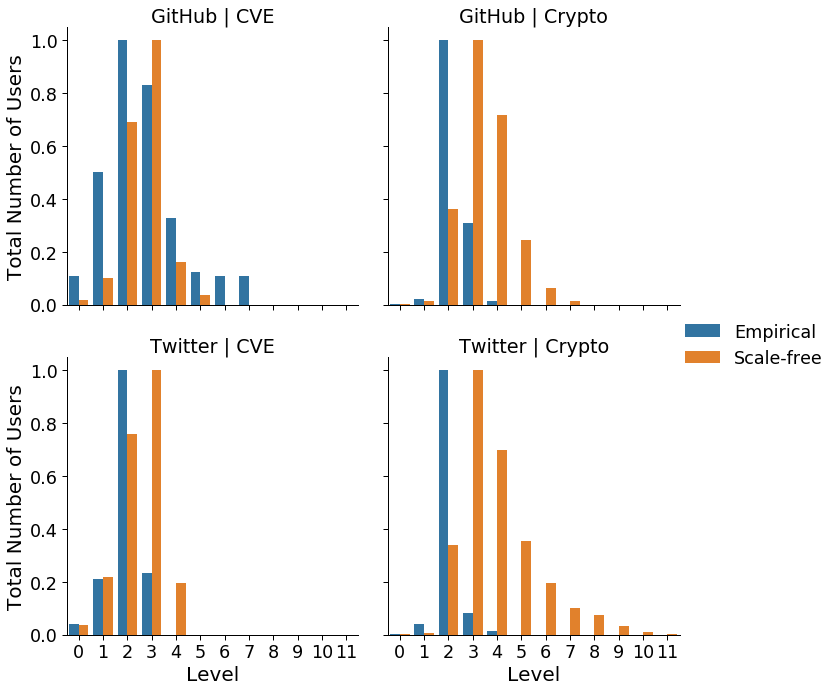

Plotting cumulative mean number of users per cascade level by platform and community


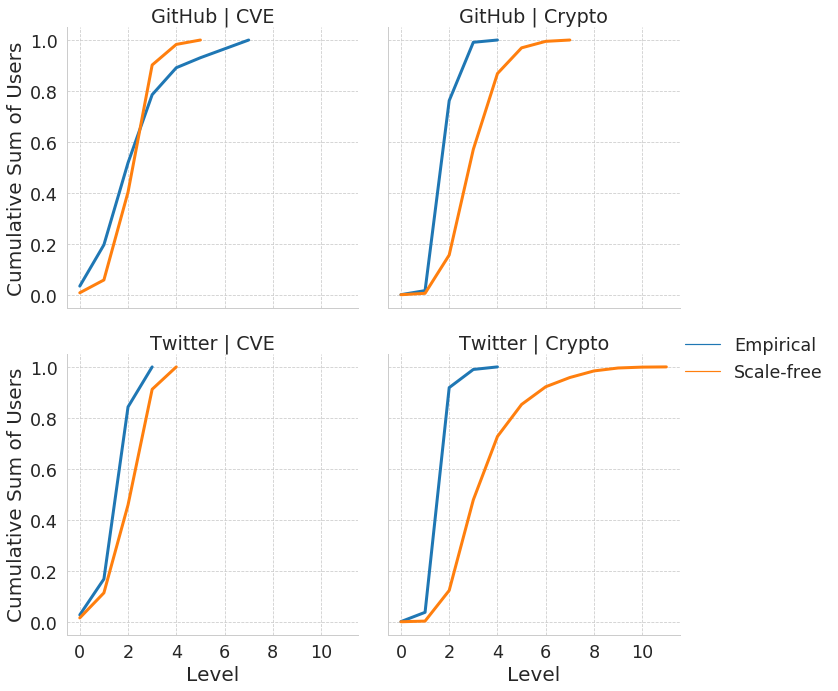

JS-divergence test of mean number of nodes distribution between each empirical network
             platform_community_comb    distance
0           (GitHub_CVE, GitHub_CVE)  0.00000000
5     (GitHub_Crypto, GitHub_Crypto)  0.00000000
10        (Twitter_CVE, Twitter_CVE)  0.00000000
15  (Twitter_Crypto, Twitter_Crypto)  0.00000000
7    (GitHub_Crypto, Twitter_Crypto)  0.16339053
13   (Twitter_Crypto, GitHub_Crypto)  0.16339053
2          (GitHub_CVE, Twitter_CVE)  0.19442346
8          (Twitter_CVE, GitHub_CVE)  0.19442346
11     (Twitter_CVE, Twitter_Crypto)  0.19831264
14     (Twitter_Crypto, Twitter_CVE)  0.19831264
6       (GitHub_Crypto, Twitter_CVE)  0.20095627
9       (Twitter_CVE, GitHub_Crypto)  0.20095627
1        (GitHub_CVE, GitHub_Crypto)  0.34141172
4        (GitHub_Crypto, GitHub_CVE)  0.34141172
3       (GitHub_CVE, Twitter_Crypto)  0.39866759
12      (Twitter_Crypto, GitHub_CVE)  0.39866759
JS-divergence test of cumulative user distributions between each network
       

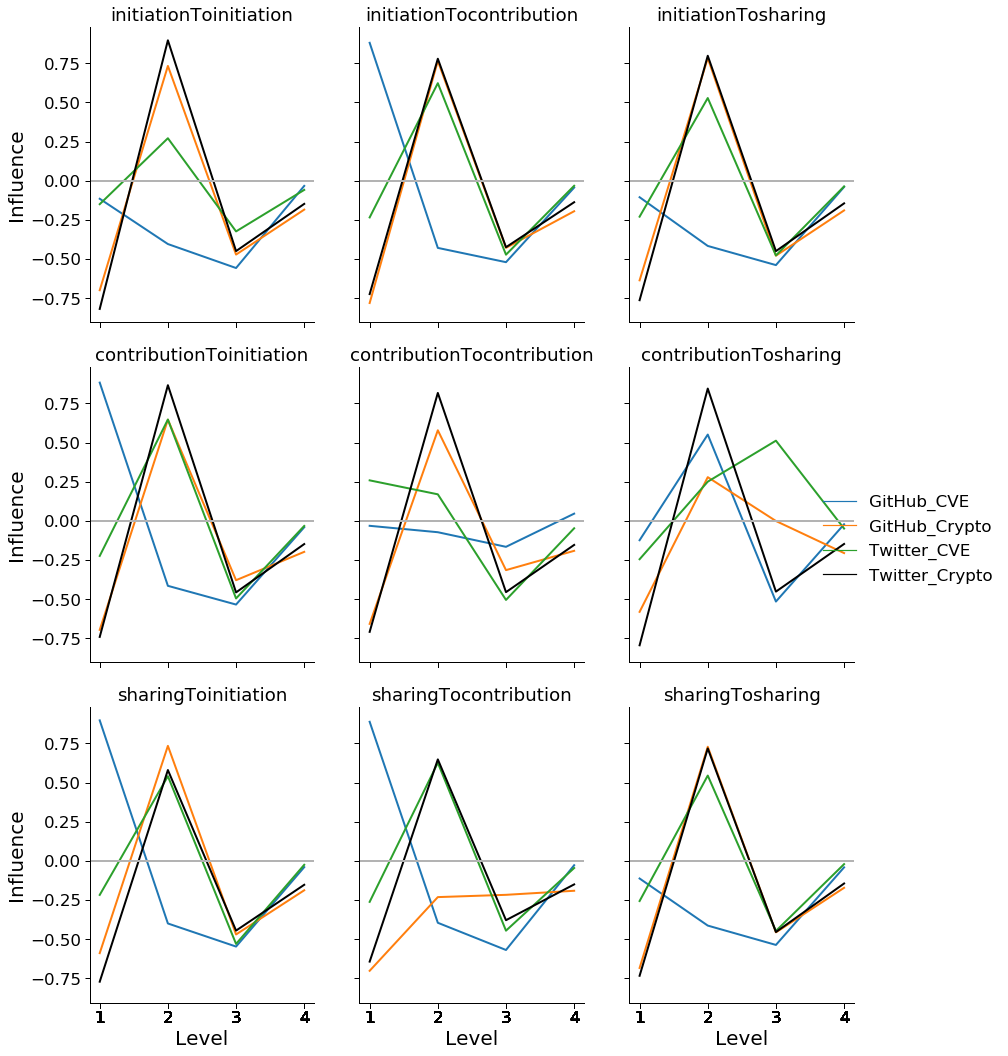

Spearmann's Correlation Test
             inf_relationship  GitHub_Crypto/GitHub_CVE_coef  \
0      initiationToinitiation                            0.0   
1    initiationTocontribution                           -0.4   
2         initiationTosharing                            0.0   
3    contributionToinitiation                           -0.4   
4  contributionTocontribution                            0.0   
5       contributionTosharing                            0.4   
6         sharingToinitiation                           -0.4   
7       sharingTocontribution                           -0.4   
8            sharingTosharing                            0.0   

   GitHub_Crypto/GitHub_CVE_p  Twitter_Crypto/Twitter_CVE_coef  \
0                         1.0                              0.8   
1                         0.6                              0.8   
2                         1.0                              0.8   
3                         0.6                              0.8   


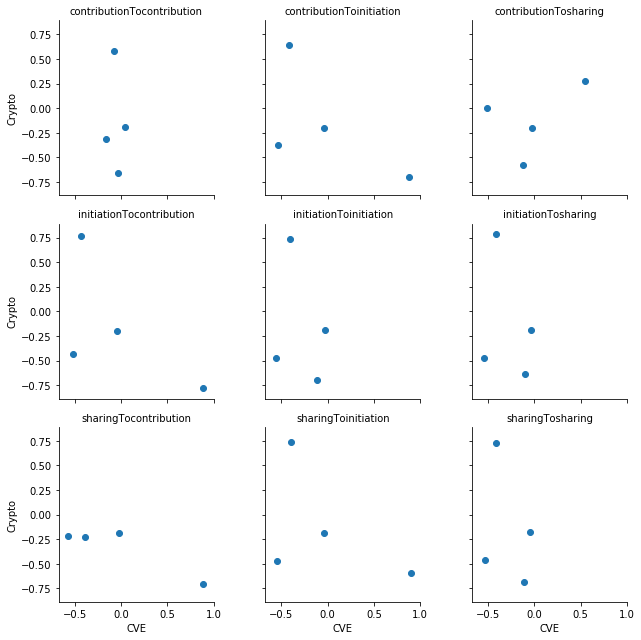

Twitter


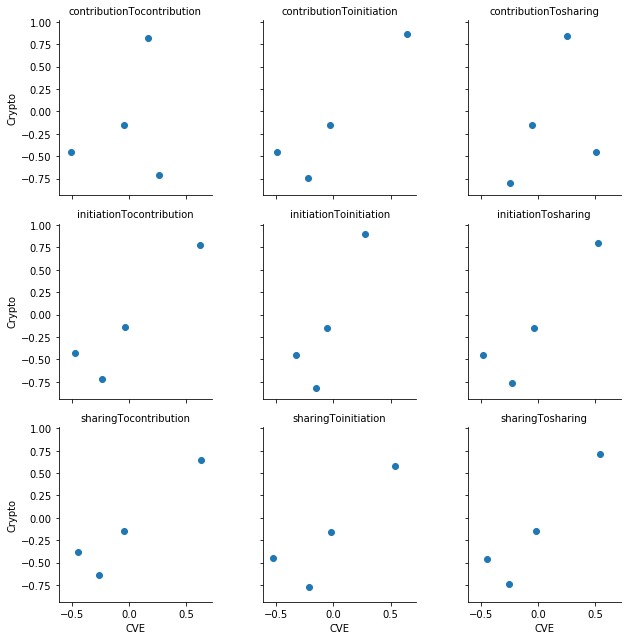

Crypto


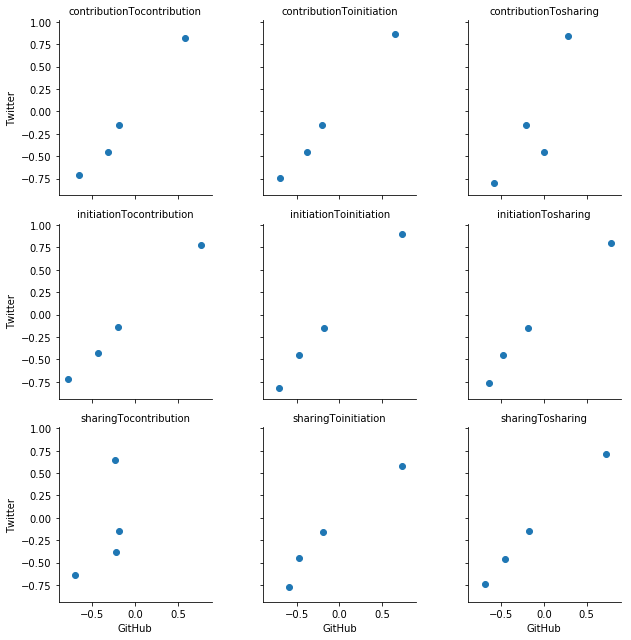

CVE


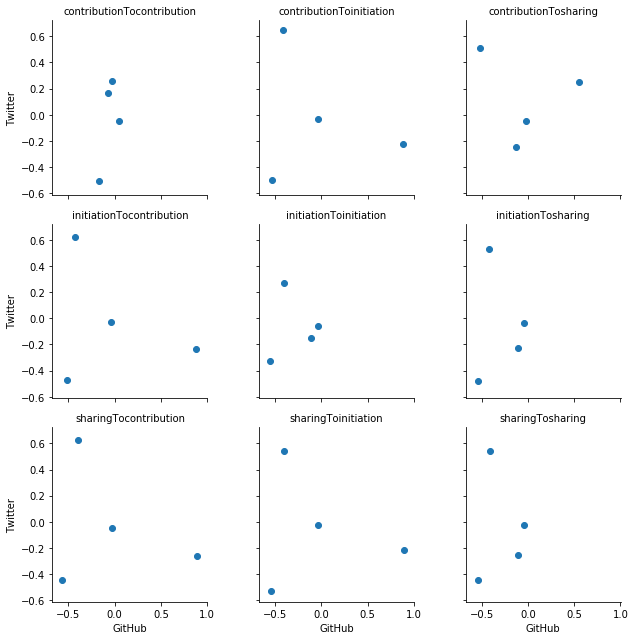

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



Three-way ANOVA Normality test
    platform_community            inf_relationship  level       stats  \
0           GitHub_CVE  contributionTocontribution      1  0.72977555   
1           GitHub_CVE  contributionTocontribution      2  0.89212662   
2           GitHub_CVE  contributionTocontribution      3  0.91483968   
3           GitHub_CVE  contributionTocontribution      4  0.77690381   
4           GitHub_CVE      contributionTocreation      1  0.29247618   
..                 ...                         ...    ...         ...   
139     Twitter_Crypto           sharingTocreation      4  1.00000000   
140     Twitter_Crypto            sharingTosharing      1  0.65456992   
141     Twitter_Crypto            sharingTosharing      2  0.64183515   
142     Twitter_Crypto            sharingTosharing      3  0.33630288   
143     Twitter_Crypto            sharingTosharing      4  1.00000000   

                  P           H_0  
0    3.10839681e-07      rejected  
1    1.13712146e-03 

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



Normality check of residuals of the three-way ANOVA model: ShapiroResult(statistic=0.7424989938735962, pvalue=0.0)


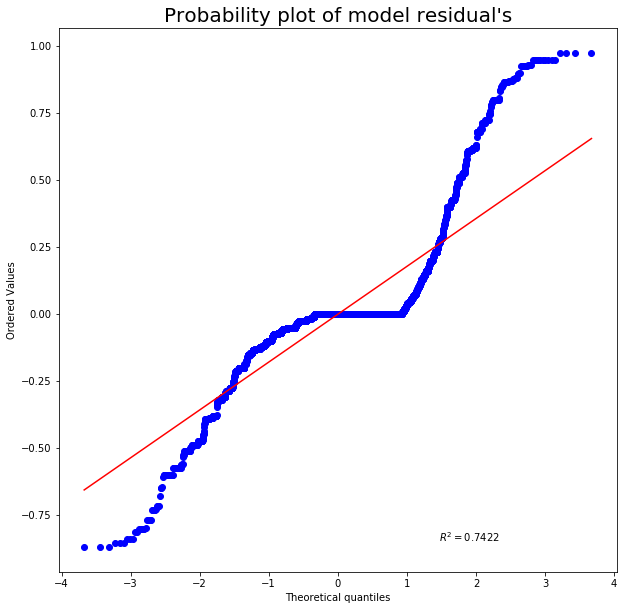

Analysis completed.
Plotting influence cascades started
empirical GitHub Crypto is plotted
sacle-free GitHub Crypto is plotted
empirical GitHub CVE is plotted
sacle-free GitHub CVE is plotted
empirical Twitter Crypto is plotted
sacle-free Twitter Crypto is plotted
empirical Twitter CVE is plotted
sacle-free Twitter CVE is plotted
Generating example scale-free null models
number of indeg zero users 2
influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0          0.34857127              0.29873179         0.31700672   
1          0.30027943              0.25890006         0.30591297   
2          0.35114930              0.44236815         0.37708031   
3          0.32768912              0.32129925         0.33708722   
4          0.56681949              0.61650905         0.60947607   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0              0.36874413                  0.34858914             0.24804222   
1      

In [75]:
Main()